# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from helper_functions import *
from statsmodels.discrete.discrete_model import Logit

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pickle
from tqdm import tqdm
from statsmodels.discrete.discrete_model import Logit
from mne.stats import fdr_correction
from scipy.stats import mannwhitneyu, pearsonr, spearmanr, kruskal
from sklearn.metrics import roc_curve, auc
import shap
from sklearn.model_selection import train_test_split

plt.rcParams['pdf.fonttype'] = 42

curr_dir = mkdirifnotexists(os.path.join('individualized_metabolic_determinants'))
metabolon_dir = mkdirifnotexists(os.path.join(curr_dir, 'metabolon'))
nigtingale_dir = mkdirifnotexists(os.path.join(curr_dir, 'nigtingale'))

# Load data

In [4]:
updated_metabs1 = pd.read_csv('additional_metabolon_files/updated_metabs1.csv', index_col=0)
updated_metabs1['SUPER_PATHWAY'] = updated_metabs1['SUPER_PATHWAY'].fillna('Unknowns')
updated_metabs1['SUB_PATHWAY'] = updated_metabs1['SUB_PATHWAY'].fillna('Unknowns')

metabolon_metabolite_name_dic = updated_metabs1['BIOCHEMICAL'].to_dict()
metabolon_metabolite_super_pathway_dic = updated_metabs1['SUPER_PATHWAY'].to_dict()
metabolon_metabolite_sub_pathway_dic = updated_metabs1['SUB_PATHWAY'].to_dict()
metabolon_metabolite_name_dic

{'100016038': '(N(1) + N(8))-acetylspermidine',
 '100006373': '1,2,3-benzenetriol sulfate (1)',
 '100006374': '1,2,3-benzenetriol sulfate (2)',
 '100008903': '1,2-dilinoleoyl-GPC (18:2/18:2)',
 '100009217': '1,2-dilinoleoyl-GPE (18:2/18:2)*',
 '100000657': '1,2-dipalmitoyl-GPC (16:0/16:0)',
 '100001397': '1,3,7-trimethylurate',
 '100001106': '1,3-dimethylurate',
 '100000580': '1,5-anhydroglucitol (1,5-AG)',
 '100001399': '1,7-dimethylurate',
 '100005372': '1-(1-enyl-oleoyl)-GPE (P-18:1)*',
 '100009014': '1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*',
 '100009002': '1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*',
 '100009009': '1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*',
 '100009069': '1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*',
 '100009007': '1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*',
 '100009005': '1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*',
 '100009160': '1-(1-enyl-palmitoyl)-2-palmitoleoyl-GPC (P-16:0/16:1)*',
 '100009162': '1-(1

In [5]:
pnp_data_metabolon = pd.read_csv(os.path.join(paper_dir, 'data/', 'pnp_data_metabolon_storage_residuals.csv'), index_col=0)
acs_data_metabolon = pd.read_csv(os.path.join(paper_dir, 'data/', 'acs_data_metabolon_storage_residuals.csv'), index_col=0).dropna(subset=['100000007'])
acs_data_metabolon['combined_outcome'] = acs_data_metabolon[['Acute MI', 'Acute stroke', 'Acute limb event', 'Unplanned PCI', 'New-onset HF', 'New-onset Afib', 'CV hospitalization including chest pain', 'CV death',]].any(1)
acs_data_metabolon['Acute_MI_or_Stroke'] = acs_data_metabolon[['Acute MI', 'Acute stroke']].any(1)
acs_data_metabolon['combined_cvd_outcome'] = acs_data_metabolon[['Acute MI', 'Acute stroke', 'Unplanned PCI', 'CV death',]].any(1)
acs_data_metabolon['Admission Diagnosis: STEMI vs UA'] = acs_data_metabolon['Admission Diagnosis: STEMI'].values
acs_data_metabolon.loc[acs_data_metabolon['Admission Diagnosis: NSTEMI'] == 1, 'Admission Diagnosis: STEMI vs UA'] = np.nan


circ_heatmap_df_sorted = pd.read_csv(os.path.join('serum_metabolomics_signatures', 'metabolon', 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0)

circ_heatmap_df_sorted.shape

Columns (43,3236) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (1,11,24,31,41,97,108,111,112,113,132,133,134,135,136,137,138,139,140,141,142,143,144,146,149,150,151,152,153,154,156,158,160,170,171,180,185,3213) have mixed types.Specify dtype option on import or set low_memory=False.


(917, 6)

## remove storage time correlated metabolties

In [7]:
storage_bad_metabs = ['X - 12462', 
                      'X - 18914', 
                      '100021107', 
                      '100020903', 
                      '100000487', 
                      '100020274', 
                      '100020908', 
                      '171', 
                      '100020275', 
                      'X - 17010', 
                      '1004', 
                      '100001323', 
                      '1099', 
                      '234', 
                      '1141', 
                      '100001296', 
                      '100001334', 
                      '100015966', 
                      '100015967', 
                      '100005372', 
                      '432', 
                      'X - 18249', 
                      '100006644', 
                      'X - 24813', 
                      '100002873']

['X - 12462',
 'X - 18914',
 '100021107',
 '100020903',
 '100000487',
 '100020274',
 '100020908',
 '171',
 '100020275',
 'X - 17010',
 '1004',
 '100001323',
 '1099',
 '234',
 '1141',
 '100001296',
 '100001334',
 '100015966',
 '100015967',
 '100005372',
 '432',
 'X - 18249',
 '100006644',
 'X - 24813',
 '100002873']

In [8]:
circ_heatmap_df_sorted = circ_heatmap_df_sorted[~circ_heatmap_df_sorted.index.isin(storage_bad_metabs)]

# Match samples

In [9]:
# for every ACS subject, create a subset of healthy control, according to: same sex, middle of age group (+- 3/5/10 years)
# for every metabolite:

def get_matched_samples(case, controls, match_by={'Age':5, 'gender':'bin'}):
#     case = pd.Series(case)
    matches = pd.Series(True, controls.index)
    for col in match_by:
        if match_by[col] == 'bin':
            matches = matches & (controls[col] == case[col].values[0])
#             print (col, matches.sum())
        elif match_by[col] > 0:
            matches = matches & (abs(controls[col]-case[col].values[0]) < match_by[col])
#             print (col, matches.sum())
    return controls.loc[matches, match_by.keys()]

a = pd.DataFrame(0, index=[0], columns=['a', 'b'])
b = pd.DataFrame(np.random.normal(0, 1, (10, 2)), index=range(10), columns=['a', 'b'])
b['b'] = [0]*5 + [1]*5
print (a, b)

get_matched_samples(a, b, match_by={'a':1, 'b':'bin'})

   a  b
0  0  0           a  b
0  1.196267  0
1 -0.907167  0
2 -0.045771  0
3 -0.169488  0
4  0.042364  0
5  0.987131  1
6  1.782819  1
7 -1.477793  1
8  0.968438  1
9 -0.386022  1


,a,b
1,-0.907167,0
2,-0.045771,0
3,-0.169488,0
4,0.042364,0


In [375]:
background_samples = {}
for age_diff in range(3, 10, 1):
    background_samples[age_diff] = {}
    for case in tqdm_notebook(acs_data_metabolon.index[:]):
        background_samples[age_diff][case] = get_matched_samples(pd.DataFrame(acs_data_metabolon.loc[case]).T, pnp_data_metabolon, match_by={'Age':age_diff, 'gender':'bin'})
        
with open(os.path.join(curr_dir, 'background_samples.pkl'), 'wb') as handle:
    pickle.dump(background_samples, handle)
background_samples_all = background_samples.copy()

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Healthy-ACS by age+sex+bmi

In [18]:
background_samples_age_sex_bmi = {}
for case in tqdm_notebook(acs_data_metabolon.index[:]):
    background_samples_age_sex_bmi[case] = get_matched_samples(pd.DataFrame(acs_data_metabolon.loc[case]).T, 
                                                               pnp_data_metabolon, 
                                                               match_by={'Age':5, 'gender':'bin', 'bmi':3})
        
with open(os.path.join(curr_dir, 'background_samples_age_sex_bmi.pkl'), 'wb') as handle:
    pickle.dump(background_samples_age_sex_bmi, handle)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Healthy metabollicaly healthy vs impaired

In [10]:
healthy_controls = pnp_data_metabolon[(pnp_data_metabolon['bmi']<=35) & 
                                      (pnp_data_metabolon['Dyslipidemia']==False) & 
                                      (pnp_data_metabolon['Hypertension']==False) &
                                      (pnp_data_metabolon['DM']==False)].index
metabollicaly_impaired_controls = pnp_data_metabolon[~pnp_data_metabolon.index.isin(healthy_controls)].index

Columns (43,3261,3277) have mixed types.Specify dtype option on import or set low_memory=False.


In [21]:
pnp_background_samples_age_sex_bmi = {}
for case in tqdm_notebook(metabollicaly_impaired_controls):
    pnp_background_samples_age_sex_bmi[case] = get_matched_samples(pd.DataFrame(pnp_data_metabolon.loc[case]).T, 
                                                               pnp_data_metabolon.loc[healthy_controls], 
                                                               match_by={'Age':5, 'gender':'bin', 'bmi':3})
        
with open(os.path.join(curr_dir, 'metab_healthy-impaired_background_samples_age_sex_bmi.pkl'), 'wb') as handle:
    pickle.dump(pnp_background_samples_age_sex_bmi, handle)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## random healthy split

In [85]:
np.random.seed(0)
random_healthy_cases = np.random.choice(pnp_data_metabolon.index, 150, replace=False)
random_healthy_controls = list(set(pnp_data_metabolon.index)-set(random_healthy_cases))

In [23]:
random_background_samples_age_sex_bmi = {}
for case in tqdm_notebook(random_healthy_cases):
    random_background_samples_age_sex_bmi[case] = get_matched_samples(pd.DataFrame(pnp_data_metabolon.loc[case]).T, 
                                                               pnp_data_metabolon.loc[random_healthy_controls], 
                                                               match_by={'Age':5, 'gender':'bin', 'bmi':3})
        
with open(os.path.join(curr_dir, 'random_background_samples_age_sex_bmi.pkl'), 'wb') as handle:
    pickle.dump(random_background_samples_age_sex_bmi, handle)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Plot Age ranges for matched controls (years)

In [13]:
with open(os.path.join(curr_dir, 'background_samples.pkl'), 'rb') as handle:
    background_samples = pickle.load(handle)
    background_samples_all = background_samples.copy()

FileNotFoundError: [Errno 2] No such file or directory: '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/ACS_study/v3/individualized_metabolic_determinants/background_samples.pkl'

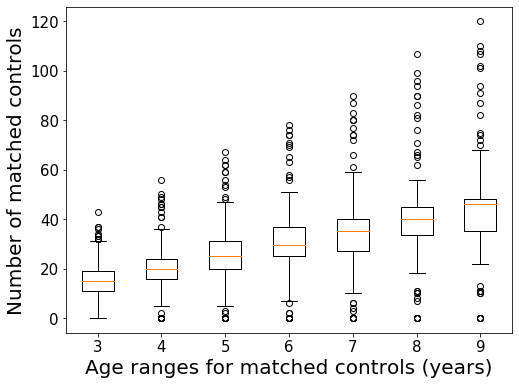

In [336]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.boxplot([[background_samples[s][c].shape[0] for c in background_samples[s]] for s in background_samples])
ax.set_xticklabels(background_samples.keys())
ax.set_ylabel('Number of matched controls', fontsize=20)
ax.set_xlabel('Age ranges for matched controls (years)', fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig(os.path.join(metabolon_dir, 'Supp_figure_ncontrols_vs_age_diff_small.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'Supp_figure_ncontrols_vs_age_diff.png'), dpi=1000, bbox_inches='tight')

In [17]:
with open(os.path.join(curr_dir, 'background_samples_age_sex_bmi.pkl'), 'rb') as handle:
    background_samples_age_sex_bmi = pickle.load(handle)
with open(os.path.join(curr_dir, 'metab_healthy-impaired_background_samples_age_sex_bmi.pkl'), 'rb') as handle:
    pnp_background_samples_age_sex_bmi = pickle.load(handle)
with open(os.path.join(curr_dir, 'random_background_samples_age_sex_bmi.pkl'), 'rb') as handle:
    random_background_samples_age_sex_bmi = pickle.load(handle)

# compute determinant scores

In [46]:
case_data = acs_data_metabolon.copy()
control_data = pnp_data_metabolon.copy()
background_samples = background_samples_age_sex_bmi.copy()
save_path = 'Supplementary_table-individual_level_scores_v2_healthy-ACS.csv'

# case_data = pnp_data_metabolon.loc[metabollicaly_impaired_controls.drop(382562)].copy() 
# control_data = pnp_data_metabolon.loc[healthy_controls].copy()
# background_samples = pnp_background_samples_age_sex_bmi.copy()
# save_path = 'Supplementary_table-individual_level_scores_v2_healthy-metab_impaired.csv'

# random_healthy_cases = list(random_background_samples_age_sex_bmi.keys())
# random_healthy_controls = list(set(pnp_data_metabolon.index)-set(random_healthy_cases))
# case_data = pnp_data_metabolon.loc[random_healthy_cases].copy()
# control_data = pnp_data_metabolon.loc[random_healthy_controls].copy()
# background_samples = random_background_samples_age_sex_bmi.copy()
# save_path = 'Supplementary_table-individual_level_scores_v2_healthy-random.csv'


good_acs_metabolomics_origin = pd.DataFrame(index=case_data.index, columns=circ_heatmap_df_sorted.drop('Healthy-ACS', axis=1).columns)
bad_acs_metabolomics_origin = pd.DataFrame(index=case_data.index, columns=circ_heatmap_df_sorted.drop('Healthy-ACS', axis=1).columns)
all_acs_metabolomics_origin = pd.DataFrame(index=case_data.index, columns=circ_heatmap_df_sorted.drop('Healthy-ACS', axis=1).columns)
good_acs_metabolomics_stds = pd.DataFrame(index=case_data.index, columns=circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].drop('Healthy-ACS', axis=1).index)
bad_acs_metabolomics_stds = pd.DataFrame(index=case_data.index, columns=circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].drop('Healthy-ACS', axis=1).index)

clip_value = 3
top_n = 100
age_diff = 3
r2_th = 0.05
samples_to_use = [s for s in background_samples if background_samples[s].shape[0]>2]
if 382562 in samples_to_use:
    samples_to_use.remove(382562)
# pval_th = 1


for case in samples_to_use:
    case_metabs = case_data.loc[case, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].index]
    temp_control_metabs = control_data.reindex(background_samples[case].index)[circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].index]
    case_stds = ((case_metabs - temp_control_metabs.mean()) / temp_control_metabs.std()).astype(float)
    case_stds[case_stds<0] = 0
    case_stds[case_stds == np.inf] = np.nan
    case_stds.clip(upper=clip_value, inplace=True)
    case_determinants_mean =(circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].drop('Healthy-ACS', axis=1) > r2_th)\
                                                .astype(float).apply(lambda x: x*case_stds.nlargest(top_n).reindex(case_stds.index)).mean()
    bad_acs_metabolomics_origin.loc[case, :] = case_determinants_mean.values
    bad_acs_metabolomics_stds.loc[case, :] = case_stds.values
    
for case in samples_to_use:
    case_metabs = case_data.loc[case, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].index]
    temp_control_metabs = control_data.reindex(background_samples[case].index)[circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].index]
    case_stds = ((temp_control_metabs.mean() - case_metabs) / temp_control_metabs.std()).astype(float)
    case_stds[case_stds<0] = 0
    case_stds[case_stds == np.inf] = np.nan
    case_stds.clip(upper=clip_value, inplace=True)
    case_determinants_mean =(circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].drop('Healthy-ACS', axis=1) > r2_th)\
                                                .astype(float).apply(lambda x: x*case_stds.nlargest(top_n).reindex(case_stds.index)).mean()
    good_acs_metabolomics_origin.loc[case, :] = case_determinants_mean.values
    good_acs_metabolomics_stds.loc[case, :] = case_stds.values
    
# combined
for case in samples_to_use:
    case_metabs = case_data.loc[case, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].index]
    temp_control_metabs = control_data.reindex(background_samples[case].index)[circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].index]
    case_stds1 = ((case_metabs - temp_control_metabs.mean()) / temp_control_metabs.std()).astype(float)
    case_stds1[case_stds1<0] = 0
    case_metabs = case_data.loc[case, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].index]
    temp_control_metabs = control_data.reindex(background_samples[case].index)[circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].index]
    case_stds2 = ((temp_control_metabs.mean() - case_metabs) / temp_control_metabs.std()).astype(float)
    case_stds2[case_stds2<0] = 0
    case_stds = pd.concat((case_stds1, case_stds2), axis=0, sort=False)
    case_stds[case_stds == np.inf] = np.nan
    case_stds.clip(upper=clip_value, inplace=True)
    case_determinants_mean =(circ_heatmap_df_sorted.drop('Healthy-ACS', axis=1) > r2_th)\
                                                .astype(float).apply(lambda x: x*case_stds.nlargest(top_n).reindex(case_stds.index)).mean()
    all_acs_metabolomics_origin.loc[case, :] = case_determinants_mean.values
    
bad_acs_metabolomics_origin = bad_acs_metabolomics_origin.astype(float)
good_acs_metabolomics_origin = good_acs_metabolomics_origin.astype(float)
all_acs_metabolomics_origin = all_acs_metabolomics_origin.astype(float)
bad_acs_metabolomics_stds = bad_acs_metabolomics_stds.astype(float)
good_acs_metabolomics_stds = good_acs_metabolomics_stds.astype(float)

metabolomics_origins = pd.concat((good_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:'ACS-depleted '+k for k in good_acs_metabolomics_origin.drop('DM-ACS', axis=1).columns}),
                  bad_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:'ACS-enriched '+k for k in bad_acs_metabolomics_origin.drop('DM-ACS', axis=1).columns}),
                  all_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:'All '+k for k in bad_acs_metabolomics_origin.drop('DM-ACS', axis=1).columns})), axis=1).dropna()

metabolomics_origins.to_csv(os.path.join(metabolon_dir, save_path))

In [47]:
metabolomics_origins_acs = pd.read_csv(os.path.join(metabolon_dir, 'Supplementary_table-individual_level_scores_v2_healthy-ACS.csv'), index_col=0)
metabolomics_origins_metab = pd.read_csv(os.path.join(metabolon_dir, 'Supplementary_table-individual_level_scores_v2_healthy-metab_impaired.csv'), index_col=0)
metabolomics_origins_random = pd.read_csv(os.path.join(metabolon_dir, 'Supplementary_table-individual_level_scores_v2_healthy-random.csv'), index_col=0)

# Analyse

## associations with features

In [48]:
features2check = ['gender', 'Age', 'Number of vessels involved', 'Admission Diagnosis: STEMI', 'Past CVA/TIA', 
                  'combined_outcome', 'Acute_MI_or_Stroke', 'Glucose Disorder: DM2', 'Known CAD', 'eGFR by CKD-EPI', 'combined_cvd_outcome']
r2s = [r2 for r2 in good_acs_metabolomics_origin.columns if r2.endswith('r2')]
good_p, bad_p, all_p = pd.DataFrame(index=features2check, columns=r2s), pd.DataFrame(index=features2check, columns=r2s), pd.DataFrame(index=features2check, columns=r2s)
for col in features2check:
    for r2 in r2s:
        for name, df, p_list in zip(['good', 'bad', 'all'], [good_acs_metabolomics_origin, bad_acs_metabolomics_origin, all_acs_metabolomics_origin], [good_p, bad_p, all_p]):
            try:
                r, p = spearmanr(acs_data_metabolon[col], df[r2], nan_policy='omit')
                p_list.loc[col, r2] = p
            except:
                continue
            if p<0.02:
                print (name, col, r2, '%0.2g'%r, '%0.2g'%p)

good Age Microbiome r2 -0.2 0.018
bad Age Diet r2 0.24 0.005
good Age Traditional Risk Factors r2 0.33 7.7e-05
all Age Traditional Risk Factors r2 0.34 7e-05
bad Past CVA/TIA Microbiome r2 0.24 0.0056
bad combined_outcome Genetics r2 -0.28 0.0012
bad Acute_MI_or_Stroke Genetics r2 -0.25 0.0033
bad Glucose Disorder: DM2 Microbiome r2 0.26 0.0024
good Glucose Disorder: DM2 Genetics r2 0.31 0.00029
all Glucose Disorder: DM2 Genetics r2 0.28 0.00094
good eGFR by CKD-EPI Diet r2 0.25 0.0043
all eGFR by CKD-EPI Diet r2 0.2 0.02
bad eGFR by CKD-EPI Traditional Risk Factors r2 -0.21 0.015
good combined_cvd_outcome Traditional Risk Factors r2 0.24 0.0048
bad combined_cvd_outcome Genetics r2 -0.27 0.0015


In [49]:
mannwhitneyu(bad_acs_metabolomics_origin.loc[acs_data_metabolon['Glucose Disorder: DM2']==1, 'Microbiome r2'].dropna(), 
             bad_acs_metabolomics_origin.loc[acs_data_metabolon['Glucose Disorder: DM2']==0, 'Microbiome r2'].dropna())
mannwhitneyu(good_acs_metabolomics_origin.loc[acs_data_metabolon['combined_cvd_outcome']==1, 'Traditional Risk Factors r2'].dropna(), 
             good_acs_metabolomics_origin.loc[acs_data_metabolon['combined_cvd_outcome']==0, 'Traditional Risk Factors r2'].dropna())
mannwhitneyu(bad_acs_metabolomics_origin.loc[acs_data_metabolon['combined_cvd_outcome']==1, 'Genetics r2'].dropna(), 
             bad_acs_metabolomics_origin.loc[acs_data_metabolon['combined_cvd_outcome']==0, 'Genetics r2'].dropna())

MannwhitneyuResult(statistic=373.0, pvalue=0.001754196010032494)

## distributions and comparison to metab impaired

In [52]:
metabolomics_origins_metab['group'] = 'Metab. impaired vs control'
metabolomics_origins_acs['group'] = 'ACS vs control'
metabolomics_origins_random['group'] = 'Control vs control (random)'
metabolomics_origins = pd.concat((metabolomics_origins_acs, metabolomics_origins_metab, metabolomics_origins_random), axis=0)

Traditional Risk Factors 2.418895310599026e-07
Diet 5.832397137225108e-09
Microbiome 2.9590676421059565e-06
Genetics 0.06268893223111509


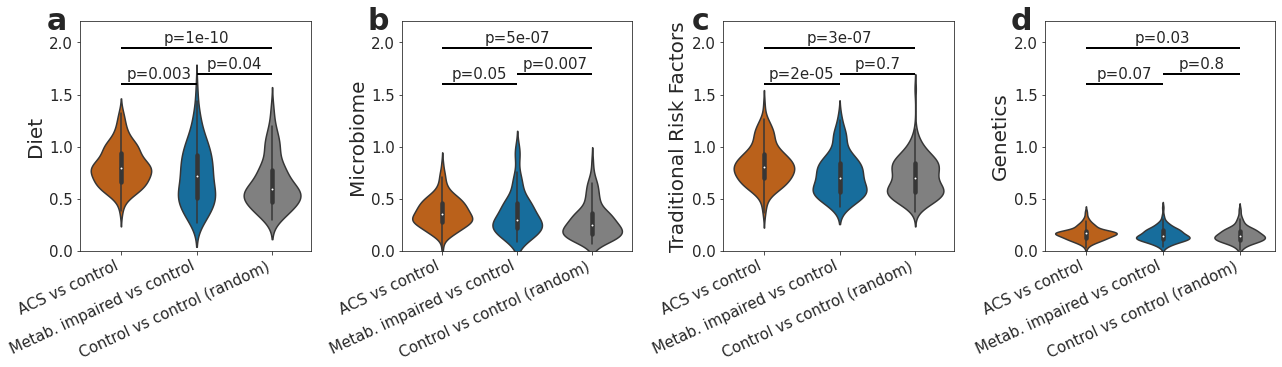

In [54]:
sns.set_style('ticks')
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
labels_fontsize = 20
tick_fontsize = 15


ax=axes[2]
r2 = 'Traditional Risk Factors'
sns.violinplot(x='group', data=metabolomics_origins, y='All ' + r2 + ' r2', ax=ax, 
               palette=[acs_color, healthy_color, 'grey'])
ax.set_ylabel(r2, fontsize=labels_fontsize)
# ax.set_xlabel('Group comparison', fontsize=labels_fontsize)
ax.set_xlabel('', fontsize=labels_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylim((0., 2.2))
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna())
xx=0.5
ax.text(xx, 1.65,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.6, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1.5
ax.text(xx, 1.75,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.7, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1
ax.text(xx, 2,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.95, xmin=xx-1, xmax=xx+1, linewidth=2, color='black')
k, p = kruskal(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
print(r2, p)

ax=axes[0]
r2 = 'Diet'
sns.violinplot(x='group', data=metabolomics_origins, y='All ' + r2 + ' r2', ax=ax, 
               palette=[acs_color, healthy_color, 'grey'])
ax.set_ylabel(r2, fontsize=labels_fontsize)
# ax.set_xlabel('Group comparison', fontsize=labels_fontsize)
ax.set_xlabel('', fontsize=labels_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylim((0., 2.2))
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna())
xx=0.5
ax.text(xx, 1.65,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.6, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1.5
ax.text(xx, 1.75,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.7, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1
ax.text(xx, 2,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.95, xmin=xx-1, xmax=xx+1, linewidth=2, color='black')
k, p = kruskal(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
print(r2, p)

ax=axes[1]
r2 = 'Microbiome'
sns.violinplot(x='group', data=metabolomics_origins, y='All ' + r2 + ' r2', ax=ax, 
               palette=[acs_color, healthy_color, 'grey'])
ax.set_ylabel(r2, fontsize=labels_fontsize)
# ax.set_xlabel('Group comparison', fontsize=labels_fontsize)
ax.set_xlabel('', fontsize=labels_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylim((0., 2.2))
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna())
xx=0.5
ax.text(xx, 1.65,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.6, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1.5
ax.text(xx, 1.75,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.7, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1
ax.text(xx, 2,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.95, xmin=xx-1, xmax=xx+1, linewidth=2, color='black')
k, p = kruskal(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
print(r2, p)

ax=axes[3]
r2 = 'Genetics'
sns.violinplot(x='group', data=metabolomics_origins, y='All ' + r2 + ' r2', ax=ax, 
               palette=[acs_color, healthy_color, 'grey'])
ax.set_ylabel(r2, fontsize=labels_fontsize)
# ax.set_xlabel('Group comparison', fontsize=labels_fontsize)
ax.set_xlabel('', fontsize=labels_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylim((0., 2.2))
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna())
xx=0.5
ax.text(xx, 1.65,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.6, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1.5
ax.text(xx, 1.75,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.7, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1
ax.text(xx, 2,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.95, xmin=xx-1, xmax=xx+1, linewidth=2, color='black')
k, p = kruskal(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
print(r2, p)

fig.tight_layout()
plt.text(-0.1, 1, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1, 'c', ha='center', va='center', transform=axes[2].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1, 'd', ha='center', va='center', transform=axes[3].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(metabolon_dir, 'Figure3.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'Figure3.pdf'), dpi=300, bbox_inches='tight')

# Plot

## homogenic patient heatmap

In [55]:
homogenic_risk_factors = acs_data_metabolon[(acs_data_metabolon['LDL'] <= 130) 
                                            & (acs_data_metabolon['LDL'] >= 70) 
                                            & (acs_data_metabolon['HbA1C'] >=1) 
                                            & (acs_data_metabolon['HbA1C'] <= 6) 
                                            & (acs_data_metabolon['Age'] >= 60) 
                                            & (acs_data_metabolon['Age'] <= 70) 
                                            & (acs_data_metabolon['gender'] == 1)].dropna(subset=['381']).index
homogenic_risk_factors.shape

(17,)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will

<Figure size 720x720 with 0 Axes>

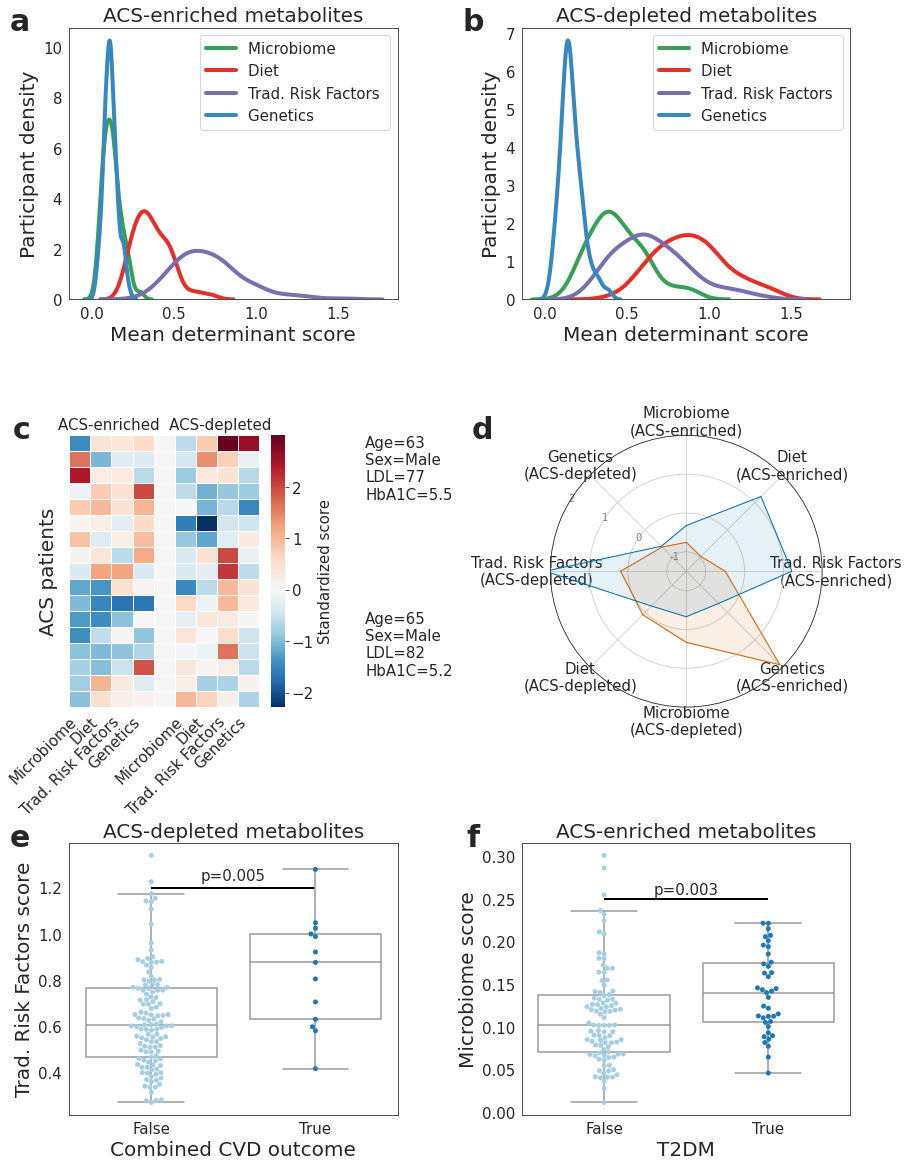

In [57]:
df1 = pd.concat((bad_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:(k).replace('Traditional', 'Trad.').split(' r2')[0]+'\n(ACS-enriched)' for k in bad_acs_metabolomics_origin.columns}), 
                          good_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:(k).replace('Traditional', 'Trad.').split(' r2')[0]+'\n(ACS-depleted)' for k in bad_acs_metabolomics_origin.columns})), axis=1).dropna()

df1 = df1.apply(lambda x: (x-x.mean())/x.std())
df1 = df1.loc[homogenic_risk_factors]
cg = sns.clustermap(df1, 
                          metric='euclidean', col_cluster=False)
plt.clf()
df1 = df1.iloc[cg.dendrogram_row.reordered_ind, :]
df = df1.copy()

fig = plt.figure(figsize=(14, 20))

gs = gridspec.GridSpec(3, 9, wspace=.6, hspace=.5)

bad_density = fig.add_subplot(gs[0, :4])
good_density = fig.add_subplot(gs[0, 5:])
heatmap = fig.add_subplot(gs[1, :3])
polar = fig.add_subplot(gs[1, 5:], projection='polar')
boxplot_nv = fig.add_subplot(gs[2, :4])
boxplot_t2d = fig.add_subplot(gs[2, 5:])

# fig, axes = plt.subplots(3, 2, figsize=(11, 15))
labels_fontsize=20
tick_fontsize=15
colors = sns.color_palette('Paired', 10)
colors = [sns.color_palette('Greens', 5)[3], sns.color_palette('Reds', 5)[3], sns.color_palette('Purples', 5)[3], sns.color_palette('Blues', 5)[3]]
feature_colors = {'Traditional Risk Factors r2': sns.color_palette('Purples', 5)[3], 'Diet r2': sns.color_palette('Reds', 5)[3], 
                  'Microbiome r2': sns.color_palette('Greens', 5)[3], 'Genetics r2': sns.color_palette('Blues', 5)[3]}


max_value = max(bad_acs_metabolomics_origin.max().max(), good_acs_metabolomics_origin.max().max())
ax = bad_density
for r2, color in zip(r2s, colors):
    sns.distplot(bad_acs_metabolomics_origin[r2], label=r2.split('r2')[0].replace('Traditional', 'Trad.'), hist=False, ax=ax, color=color, kde_kws={"lw": 4, 'alpha':0.7})
ax.set_xlabel('Mean determinant score', fontsize=labels_fontsize)
ax.set_ylabel('Participant density', fontsize=labels_fontsize)
ax.set_title('ACS-enriched metabolites', fontsize=labels_fontsize)
ax.legend(loc='best', fontsize=tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)

ax = good_density
for r2, color in zip(r2s, colors):
    sns.distplot(good_acs_metabolomics_origin[r2], label=r2.split('r2')[0].replace('Traditional', 'Trad.'), hist=False, ax=ax, color=color, kde_kws={"lw": 4, 'alpha':0.7})
ax.set_xlabel('Mean determinant score', fontsize=labels_fontsize)
ax.set_ylabel('Participant density', fontsize=labels_fontsize)
ax.set_title('ACS-depleted metabolites', fontsize=labels_fontsize)
ax.legend(loc='best', fontsize=tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlim(bad_density.get_xlim())

colors = sns.color_palette('Paired', 10)

ax = boxplot_nv
c='combined_cvd_outcome'
r2 = 'Traditional Risk Factors r2'
origins = good_acs_metabolomics_origin.copy()
sns.boxplot(data=pd.concat((acs_data_metabolon[c], origins[r2]), axis=1), x=c, y=r2, ax=ax, palette=['white'], showfliers=False)
sns.swarmplot(data=pd.concat((acs_data_metabolon[c], origins[r2]), axis=1), x=c, y=r2, ax=ax, palette=colors)
ax.set_title('ACS-depleted metabolites', fontsize=labels_fontsize)
ax.set_xlabel('Combined CVD outcome', fontsize=labels_fontsize)
ax.set_ylabel(r2.split('r2')[0].replace('Traditional', 'Trad.') + 'score', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# ax.set_yticks([0, 0.005, 0.01, 0.015, 0.02])
# ax.set_ylim((0, 0.018))
# r, p = spearmanr(acs_data_metabolon[c], bad_acs_metabolomics_origin[r2], nan_policy='omit')
# add_text_at_corner(ax, r'Spearman $\rho$=%0.2g, p=%0.2g'%(r, bad_p.loc[c, r2]), 'top left', fontsize=tick_fontsize)
t, p = mannwhitneyu(origins.loc[acs_data_metabolon[c]==1, r2].dropna(), origins.loc[acs_data_metabolon[c]==0, r2].dropna())
xx=0.5
ax.text(xx, 1.23,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.2, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')


ax = boxplot_t2d
c='Glucose Disorder: DM2'
r2 = 'Microbiome r2'
sns.boxplot(data=pd.concat((acs_data_metabolon[c], bad_acs_metabolomics_origin[r2]), axis=1), x=c, y=r2, ax=ax, palette=['white'], showfliers=False)
sns.swarmplot(data=pd.concat((acs_data_metabolon[c], bad_acs_metabolomics_origin[r2]), axis=1), x=c, y=r2, ax=ax, palette=colors)
ax.set_title('ACS-enriched metabolites', fontsize=labels_fontsize)
ax.set_xlabel('T2DM', fontsize=labels_fontsize)
ax.set_ylabel(r2.split('r2')[0] + 'score', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# ax.set_yticks([0, 0.005, 0.01, 0.015, 0.02])
ax.set_xticklabels([False, True])
# ax.set_ylim((0, 0.018))
# r, p = spearmanr(acs_data_metabolon[c], bad_acs_metabolomics_origin[r2], nan_policy='omit')
# add_text_at_corner(ax, r'Spearman $\rho$=%0.2g, p=%0.2g'%(r, bad_p.loc[c, r2]), 'top left', fontsize=tick_fontsize)
t, p = mannwhitneyu(bad_acs_metabolomics_origin.loc[acs_data_metabolon[c]==1, r2].dropna(), bad_acs_metabolomics_origin.loc[acs_data_metabolon[c]==0, r2].dropna())
xx=0.5
ax.text(xx, 0.255,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=0.25, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')



# Libraries
from math import pi


couple = [3031317, 3655837] #[3031317, 3655837] [3339392, 3168327]


sns.set_style('white')
ax = heatmap# ax = plt.subplot(131)
norm1 = MidpointNormalize(vmin=df.min().min(), 
                          vmax=df.max().max(), 
                          midpoint=0)

heatmap_df = df.copy()
heatmap_df[''] = [0]*df.shape[0]
heatmap_df = heatmap_df.loc[:, df.columns[:4].tolist() + [''] + df.columns[4:].tolist()]
sns.set_style('white')
sns.heatmap(heatmap_df.rename(columns={k:k.split('\n')[0] for k in df.columns}), cmap='RdBu_r', ax=ax, norm=norm1, 
            linecolor='white', linewidth=1, cbar_kws={'label': 'Standardized score', 'ticks':[-2, -1, 0, 1, 2]})
ax.figure.axes[-1].set_ylabel('Standardized score', size=tick_fontsize)
ax.figure.axes[-1].tick_params(labelsize=tick_fontsize)
# ax.figure.axes[-1].set_xticks([-1, 0, 1])
ax.set_yticklabels([])
ax.set_ylabel('ACS patients', fontsize=labels_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=tick_fontsize, ha='right')
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(3)
#     spine.set_color('white')
# ax.add_patch(Rectangle((4, 0), 0, df.shape[0], fill=False, edgecolor='white', lw=5))
ax.set_title('ACS-enriched  ACS-depleted', fontsize=tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)

ax.text(14, 4, 'Age=63\nSex=Male\nLDL=77\nHbA1C=5.5', fontsize=tick_fontsize)
ax.text(14, df.shape[0]-2, 'Age=65\nSex=Male\nLDL=82\nHbA1C=5.2', fontsize=tick_fontsize)
 
# Set data
# df = df.loc[couple].filter(regex='depleted')
df = df.loc[couple]
 
#  df = df.rename({k:k.replace('good ', '').replace('bad ', '')})
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# ax.plot([0, 1], [0, 1])
# ax = plt.subplot(133, projection='polar')
# ax = plt.subplot(111, polar=True)
# ax = axes[0]
ax = polar
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, ha='center', fontsize=tick_fontsize)
 
# Draw ylabels
ax.set_rlabel_position(300)
ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_yticklabels(["-2", "-1","0","1", '2'], color="grey", size=10)
ax.set_ylim(-1.5, 2)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.iloc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=couple[0], color=acs_color)
ax.fill(angles, values, alpha=0.1, color=acs_color)
 
# Ind2
values=df.iloc[1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=couple[1], color=healthy_color)
ax.fill(angles, values, alpha=0.1, color=healthy_color)
 
# Add legend
# plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
fig.tight_layout()

x, y = -0.15, 1.02
plt.text(x, y, 'a', ha='center', va='center', transform=bad_density.transAxes, fontsize=30, weight = 'bold')
plt.text(x, y, 'b', ha='center', va='center', transform=good_density.transAxes, fontsize=30, weight = 'bold')
plt.text(x-0.1, y, 'c', ha='center', va='center', transform=heatmap.transAxes, fontsize=30, weight = 'bold')
plt.text(x-0.1, y, 'd', ha='center', va='center', transform=polar.transAxes, fontsize=30, weight = 'bold')
plt.text(x, y, 'e', ha='center', va='center', transform=boxplot_nv.transAxes, fontsize=30, weight = 'bold')
plt.text(x, y, 'f', ha='center', va='center', transform=boxplot_t2d.transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(metabolon_dir, 'Figure2.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'Figure2.pdf'), dpi=300, bbox_inches='tight')

#### extended figure

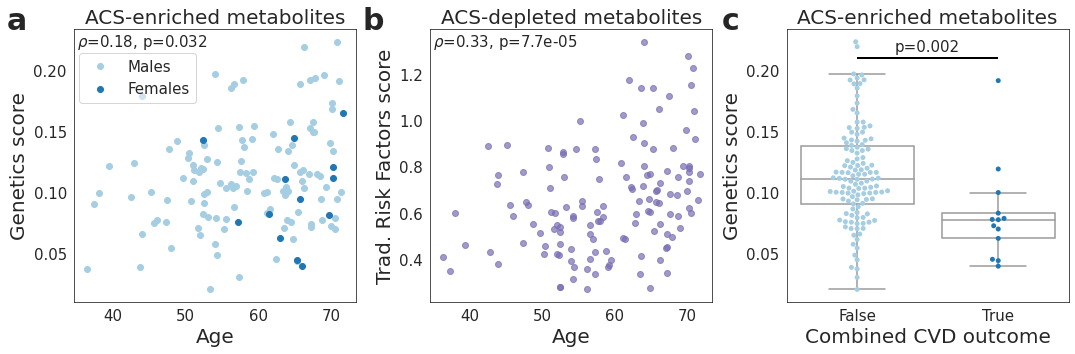

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
c='Age'
r2 = 'Genetics r2'
ax.plot(acs_data_metabolon.loc[acs_data_metabolon['gender']==1][c], bad_acs_metabolomics_origin.loc[acs_data_metabolon['gender']==1][r2], 'o', color=colors[0], label='Males')
ax.plot(acs_data_metabolon.loc[acs_data_metabolon['gender']==0][c], bad_acs_metabolomics_origin.loc[acs_data_metabolon['gender']==0][r2], 'o', color=colors[1], label='Females')
ax.set_title('ACS-enriched metabolites', fontsize=labels_fontsize)
ax.set_xlabel(c, fontsize=labels_fontsize)
ax.set_ylabel(r2.split('r2')[0] + 'score', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.set_yticks([0.05, 0.1, 0.15, 0.2])
ax.legend(fontsize=tick_fontsize, loc=(0.02, 0.73))
r, p = spearmanr(acs_data_metabolon[c], bad_acs_metabolomics_origin[r2], nan_policy='omit')
add_text_at_corner(ax, r'$\rho$=%0.2g, p=%0.2g'%(r, bad_p.loc[c, r2]), 'top left', fontsize=tick_fontsize)

ax = axes[1]
c='Age'
r2 = 'Traditional Risk Factors r2'
ax.plot(acs_data_metabolon[c], good_acs_metabolomics_origin[r2], 'o', color=feature_colors[r2], alpha=0.7)
ax.set_title('ACS-depleted metabolites', fontsize=labels_fontsize)
ax.set_xlabel(c, fontsize=labels_fontsize)
ax.set_ylabel(r2.split('r2')[0].replace('itional', '.') + 'score', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)

r, p = spearmanr(acs_data_metabolon[c], good_acs_metabolomics_origin[r2], nan_policy='omit')
add_text_at_corner(ax, r'$\rho$=%0.2g, p=%0.2g'%(r, good_p.loc[c, r2]), 'top left', fontsize=tick_fontsize)

ax = axes[2]
c='combined_cvd_outcome'
r2 = 'Genetics r2'
sns.boxplot(data=pd.concat((acs_data_metabolon[c], bad_acs_metabolomics_origin[r2]), axis=1), x=c, y=r2, ax=ax, palette=['white'], showfliers=False)
sns.swarmplot(data=pd.concat((acs_data_metabolon[c], bad_acs_metabolomics_origin[r2]), axis=1), x=c, y=r2, ax=ax, palette=colors)
ax.set_title('ACS-enriched metabolites', fontsize=labels_fontsize)
ax.set_xlabel('Combined CVD outcome', fontsize=labels_fontsize)
ax.set_ylabel(r2.split('r2')[0] + 'score', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.set_yticks([0.05, 0.1, 0.15, 0.2])
t, p = mannwhitneyu(bad_acs_metabolomics_origin.loc[acs_data_metabolon[c]==1, r2].dropna(), bad_acs_metabolomics_origin.loc[acs_data_metabolon[c]==0, r2].dropna())
xx=0.5
ax.text(xx, 0.215,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=0.21, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')

fig.tight_layout()
x, y = -0.2, 1.03
plt.text(x, y, 'a', ha='center', va='center', transform=axes[0,].transAxes, fontsize=30, weight = 'bold')
plt.text(x, y, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')
plt.text(x, y, 'c', ha='center', va='center', transform=axes[2].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(metabolon_dir, 'ExtendedDataFigure4.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'ExtendedDataFigure4.pdf'), dpi=300, bbox_inches='tight')